In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [41]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [42]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
session = Session(engine)

In [44]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23c3292df08>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

In [45]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23c32940888>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [46]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [47]:
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [48]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,
       Measurement.prcp]
m_data = session.query(*sel).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

In [49]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_m = pd.DataFrame(m_data, columns=['date', 'prcp'])
#df_m

([], <a list of 0 Text xticklabel objects>)

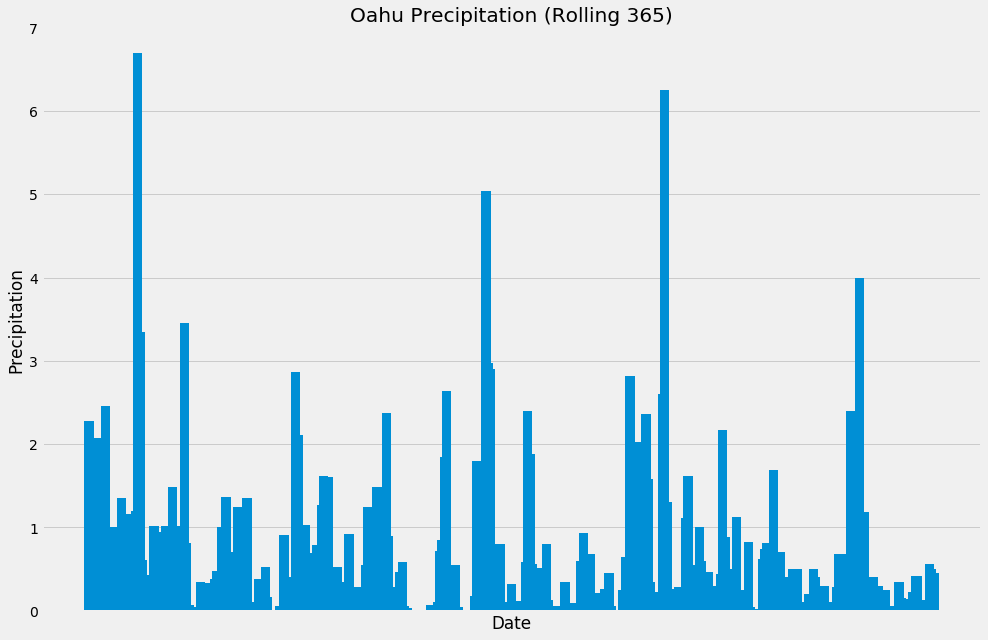

In [50]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.bar(df_m["date"], df_m["prcp"], width=4)
plt.title("Oahu Precipitation (Rolling 365)")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.ylim(0, 7)
plt.xticks([])

In [51]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_p.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
station_ct=session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_ct} distinct stations is the Measurement dataset")

There are 9 distinct stations is the Measurement dataset


In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_cts=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
df_station_cts = pd.DataFrame(station_cts, columns=['Station', 'Count'])
df_station_cts

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [54]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
df_station_stats = pd.DataFrame(station_stats, columns=['Min Temp', 'Max Temp', 'Avg Temp'])
df_station_stats

,Min Temp,Max Temp,Avg Temp
0,54.0,85.0,71.663781


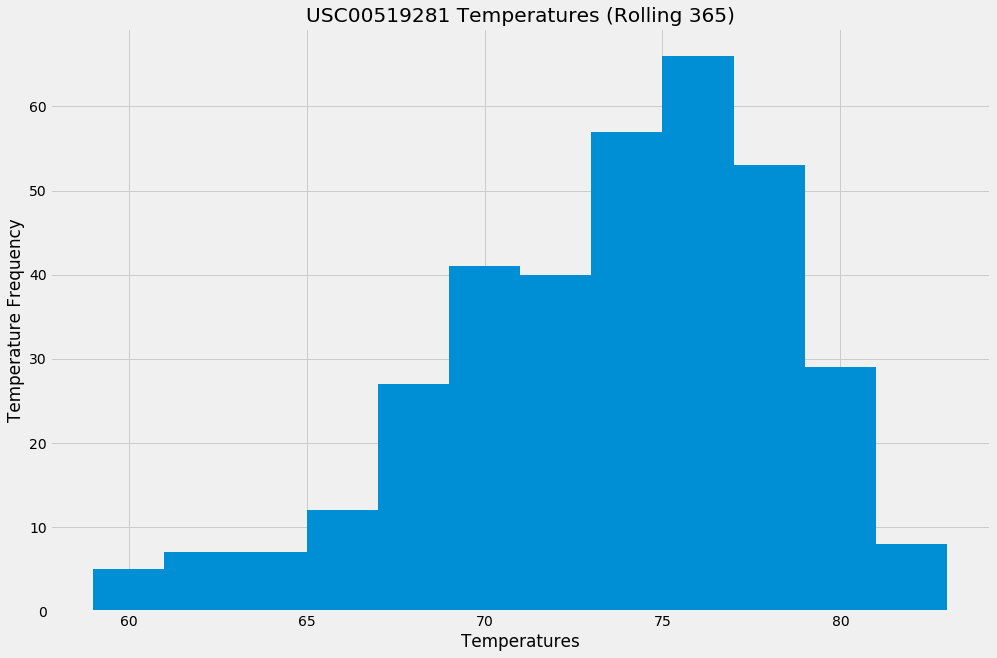

In [62]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_data=session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= dt.date(2017, 8, 23) - dt.timedelta(days=365)).all()

hist_data_df=pd.DataFrame(hist_data)

#plt.hist(hist_data_df["tobs"],bins=12)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.hist(hist_data_df["tobs"],bins=12)
plt.ylabel("Temperature Frequency")
plt.xlabel("Temperatures")
plt.title("USC00519281 Temperatures (Rolling 365)")
plt.show()

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [77]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-08-10'
end_date = '2017-08-23'
calc_temps_df = calc_temps(start_date, end_date)
calc_temps_df = pd.DataFrame(calc_temps_df, columns=['Tmin', 'Tave', 'Tmax'])
calc_temps_df

,Tmin,Tave,Tmax
0,70.0,78.714286,85.0


In [78]:
Tmax = calc_temps_df["Tmax"].iloc[0]
Tmax

85.0

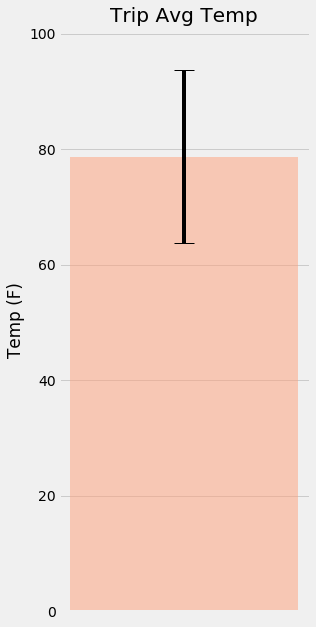

In [102]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Tmin = calc_temps_df["Tmin"].iloc[0]
Tave = calc_temps_df["Tave"].iloc[0]
Tmax = calc_temps_df["Tmax"].iloc[0]

error = Tmin-Tmax

plt.figure(figsize=(4, 10))
plt.bar(1, Tave,
        color='lightsalmon',
        yerr=error,
        alpha=0.5,
        capsize=10)
plt.ylim(0, 101)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`